## **0 - Introduction and Install Dependencies** (_if needed_)

Hello. If you are seeing this notebook for the first time and would like to run it, please follow these steps. Note that you will need several (>4) GB of free space in order to succesfully do the following:

1) In the same directory where this notebook is currently located on your device, make a new folder called "data\".
2) Visit this [page on Kaggle](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) and download the dataset.
3) Extract the data from the compressed file into the "data\" folder, such that your current directory mirrors the following (thank you for helping me generate this figure ChatGPT):

```
root_directory
   |- exploratory_analysis.ipynb
   |- data
      |- asl_alphabet_test
         |- data...
      |- asl_alphabet_train
         |- data...
```

In [1]:
#%pip install -U tqdm
#%pip install -U scikit-learn
#%pip install -U opencv-python
#%pip install -U matplotlib
#%pip install -U tensorflow
#%pip install -U pandas
#%pip install -U numpy

## **1 - Load Dependencies**

In [2]:
import sys
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import sklearn
from cv2 import imread
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from tensorflow.keras import layers
import random

## **2 - Utility for Loading Data** 

Our dataset is (relatively) massive. For this reason, we must specify some custom classes and methods to allow us to perform batch loading. It is infeasible to load it all into memory at once. ASLDataPaths retrieves all paths of the training data images. This is more efficient than, say, loading all individual images corresponding to those paths into memory at once. We will then be able to lookup those paths later when we load batches of our dataset. 

**NOTE** _(for those with the full repo)_: The following dataloader classes are found under /util/dataset.py. Be sure that any finalized modifications on dataset.py make it to this notebook and vice versa. The reason that I have separately saved/duplicated the ASLDataPaths and ASLBatchLoader classes is to import them as modules in the actual train.py script that will run on the high performance computer (HPC) for training purposes. This notebook will not be run on the HPC. This notebook is to play around with.

Please see [this TF documentation page](https://www.tensorflow.org/api_docs/python/tf/keras/utils/PyDataset) for more details on our source for implementing batch loading. Also, this [video](https://www.youtube.com/watch?v=9OUJ-UluCyc) on Youtube.

In [3]:
# The directory where the data is stored. Training and testing, respectively.
train_data = './data/asl_alphabet_train/asl_alphabet_train/'
test_data = './data/asl_alphabet_test/asl_alphabet_test/'

In [4]:
class ASLDataPaths():
    '''
    fetchASLDataPaths is a class that fetches the paths of the ASL dataset from a directory. The rationale behind such a class
    is the fact that our dataset is huge (relatively speaking), and we can not afford to load the entire dataset of images into memory.
    Rather, it might be a better idea to load the paths of the images, and then load the images in batches as we train our model. 
    '''

    def __init__(self, data_dir: str):

        # Check if the data directory exists
        if type(data_dir) != str or not os.path.exists(data_dir):
            raise FileNotFoundError(f"The directory {data_dir} does not exist.")
        self.data_dir = data_dir

    def fetch_paths(self):
        X_paths = []
        y = []

        # Walk over the data directory and fetch the paths of all images, label in the dataset
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                X_paths.append(os.path.join(root, file))
                y.append(os.path.basename(root))
        
        X_paths = np.array(X_paths)
        y = np.array(y)
        return X_paths, y

In [5]:
# The ASLBatchLoader class is a custom data loader following the concept of this documentation code: 
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/PyDataset. Refer to this documentation for more information
# and context on how to implement a custom data loader in TensorFlow.
class ASLBatchLoader(tf.keras.utils.PyDataset):

    def __init__(self, 
                 X_set: np.array, 
                 y_set: np.array,
                 batch_size: int = 32, 
                 transform = None):
        '''
        The ASLBatchLoader class is a custom data loader that loads the ASL dataset in batches.
        
        Parameters:
            X_set: np.array - A numpy array containing the paths of the images and 
            y_set: np.array - their corresponding labels.
            batch_size: int - The size of the batch that we want to load the data in.
        '''
        self.X_set = X_set
        self.y_set = y_set
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        '''
        This function returns the number of batches that we can load from the dataset.
        
        Returns: int - The number of batches that we can load from the dataset.
        '''
        return math.ceil(len(self.X_set) / self.batch_size)

    def __getitem__(self, index):
        '''
        This function loads a batch of data from the dataset.

        Parameters:
            index: int - The index of batch that we want to load from the dataset.

        Returns:
            X_batch: np.array - A numpy array containing the images of the batch.
            y_batch: np.array - A numpy array containing labels of the batch.
        '''

        # We specify the start of our batch
        batch_start = index * self.batch_size

        # If the batch end is greater than the length of the data directory, we set the batch end to the length of the data directory
        batch_end = min(batch_start + self.batch_size, len(self.X_set))

        # These are the paths that we immediately work with in this iteration of the batching process
        X_path_batch = self.X_set[batch_start:batch_end]
        y_batch = self.y_set[batch_start:batch_end]

        # Load the images and labels from the paths
        # If a transformation is specified, we apply it to the images
        # If no transformation is specified, we simply load the images
        # A transformation is typically something like normalization, resizing, etc.
        X_batch = np.array([cv2.imread(file) for file in X_path_batch])
        if self.transform is not None:
            X_batch = self.transform(X_batch)

        return X_batch, y_batch        

## **3 - Processing Data**

**NOTE**: Feel free to add any kind of transformation on the images you would like to see visualized. Please refer to the documentation linked below to see the available options.

For classification tasks on images, we like to apply augmentations/transformations on the original images. This can be anything from normalizing the pixel values from a range of [0-255] to [0-1], resizing images, rotations, to, color/contrast manipulations, etc... This is analogous to Sklearn's pipeline feature where we can specify what to do with our data (impute, standard scaling, etc...). 

From a training standpoint, this is very powerful. We can apply resizing and grayscaling transformations to reduce the complexity/resolution of the images, and consequently improve overall training time. While this is information loss, it may not be catastrophic in this kind of task. Additionally, we can apply other kinds of transformations that would make our model more robust to difficult classification scenarios (rotations, manipulations for low contrast and bright settings, mirroring - particularly important as a distinction between left and right handed signers, etc...).

Please see [this TF documentation page](https://www.tensorflow.org/tutorials/images/data_augmentation) to understand how we figured out/use data augmentation techniques in TF.

In [6]:
# Batch size for the data loader. NOTE: feel free to change this.
batch_size = 32

# Grayscale transformation.
def grayscale(img):
    return tf.image.rgb_to_grayscale(img)

# At least some degree of resizing and rescaling is the bare minimum often used for transformations. NOTE: feel free to add more.
# We follow the linked documentation to understand how to use Sequential transformations.
transform = tf.keras.Sequential([layers.Resizing(64, 64),
                                 layers.Rescaling(1./255),
                                 layers.RandomFlip("horizontal"),
                                 layers.RandomRotation(0.2),
                                 layers.Lambda(grayscale)]) # <-- See documentation linked above. Used it to figure out how to use lambda layer.

We then apply our loaders and perform the splitting as usual. X_path is an array of paths to X images. y is the standalone array of labels to those images.

In [7]:
# Load the data paths
X_path, y = ASLDataPaths(data_dir = train_data).fetch_paths()
X_train_path, X_test_path, y_train, y_test = train_test_split(X_path, y, test_size=0.1, random_state=42, shuffle=True)
X_train_path, X_val_path, y_train, y_val = train_test_split(X_train_path, y_train, test_size=0.2, random_state=42, shuffle=True)

# Load the data into our batchloader
train_batch_loader = ASLBatchLoader(X_set = X_train_path, y_set = y_train, batch_size=batch_size, transform = transform)
val_batch_loader = ASLBatchLoader(X_set = X_val_path, y_set = y_val, batch_size=batch_size, transform = transform)
test_batch_loader = ASLBatchLoader(X_set = X_test_path, y_set = y_test, batch_size=batch_size, transform = transform)

Lets take some batch from the val_batch_loader. Doesn't matter which batch because of shuffling, as long is it is less than the len(ASLBatchLoader).

In [8]:
batch_idx = 13
X_batch_val, y_batch_val = val_batch_loader[batch_idx]

The shape makes sense. We have n_0 = 32 images in a given batch, of img_size * img_size = 64, 1 channel in grayscale, 32 corresponding labels.

In [9]:
X_batch_val.shape, y_batch_val.shape

(TensorShape([32, 64, 64, 1]), (32,))

## **4 - Inspect and Analyze**

Lets inspect that the image is correct. It appears that there is a nice balance of images with variable lighting, position, scale (more representative data of an in real life scenario perhaps?).

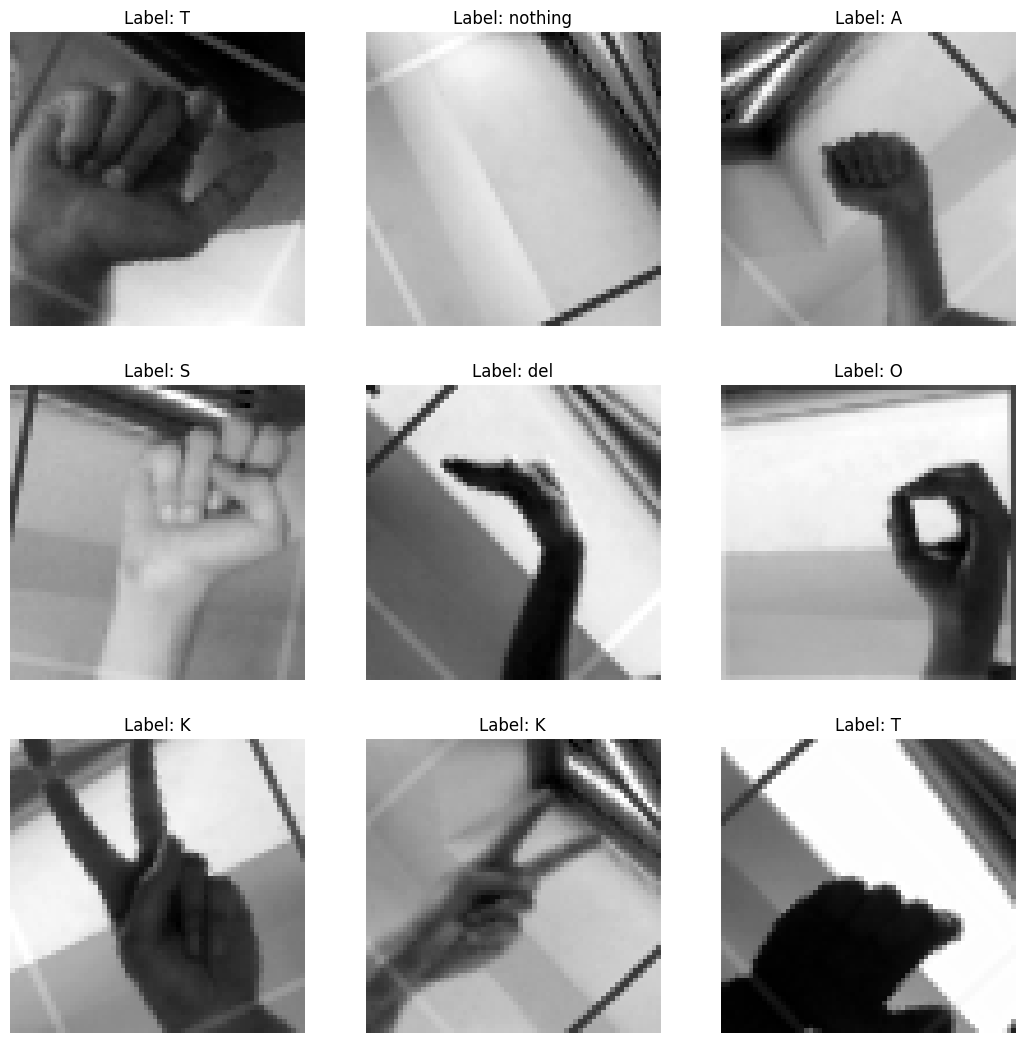

In [10]:
def visualize_X(X, 
                y, 
                grayscale=False, 
                n_col = 1, 
                n_row = 1,
                random_seed = 42):
    '''
    This function visualizes the images in the dataset.

    Parameters:
        X: np.array - The images in the dataset.
        y: np.array - The labels in the dataset.
        grayscale: Bool - Whether or not the images are in grayscale.
        n_col: int - The number of columns in the plot.
        n_row: int - The number of rows in plot.
        random_seed: int - The random seed.
    '''
    random.seed(random_seed)

    # Depending on which transformation is applied, since imshow needs a color mapping.
    if grayscale:
        color = 'gray'
    else:
        color = 'viridis'

    # Basic safety check to ensure there exist enough images. Then, get the random indices.
    if n_col * n_row > len(y):
        raise ValueError("The number of columns and rows can not be greater than the number of images.")
    indices = random.choices(range(len(y)), k= n_col * n_row)

    # Plot the images and labels
    random.seed(42)
    fig, axes = plt.subplots(n_row, n_col, figsize=(13, 13))
    for i in range(n_row):
        for j in range(n_col):
            axes[i, j].imshow(X[indices[i * n_col + j]], cmap=color)
            axes[i, j].set_title(f"Label: {y[indices[i * n_col + j]]}")
            axes[i, j].axis('off')
    plt.show()

visualize_X(X_batch_val, y_batch_val, grayscale=True, n_col=3, n_row=3, random_seed=42)

As we can see, the distribution of labels appears uniform (something that makes clear sense if you inspect raw_data). Relatively balanced! 

What does this mean for our potential metrics? For one, we could use some variation of ROC-AUC adapted for multi-class classification (one vs. all or averaging). Though, we perhaps might think about confusion matrices to understand errors at hand better and other metrics such as a precision, recall, F1 (individual and averaged).

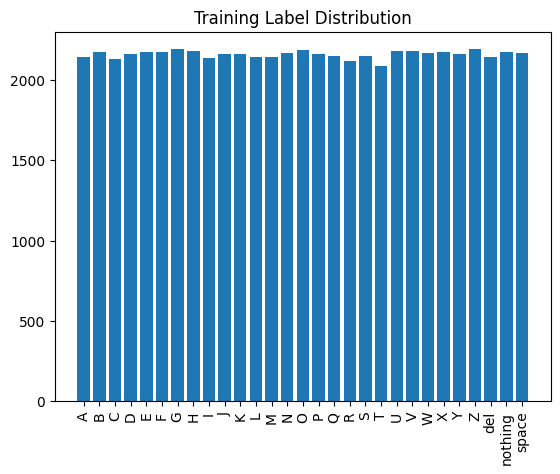

In [11]:
# Lets check how balanced the training dataset is
unique_labels, label_counts = np.unique(y_train, return_counts=True)

plt.title('Training Label Distribution')
plt.bar(unique_labels, label_counts)
plt.xticks(rotation=90)
plt.show()

**Future Avenues of Exploration and Analysis**

The following are ideas for visualizations that may be handy once we have actually trained some form of model. Heatmaps, for example, in terms of classification explainability. What is it about the orientation, positioning, placement of fingers and hand that leads our classifier to make a prediction? This is a proposed area of expansion if time permits - not a guaranteed avenue of exploration.

- https://glassboxmedicine.com/2019/06/11/cnn-heat-maps-class-activation-mapping-cam/
- https://arxiv.org/abs/2304.02202